<a href="https://colab.research.google.com/github/VitalyGladyshev/NeuroN/blob/master/HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ_04

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, MaxPooling2D
# from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras import optimizers

from typing import List, Tuple

In [ ]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

## AlexNet

In [ ]:
# Количество классов изображений
nb_classes = 10
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# y_train10 = utils.to_categorical(y_train, nb_classes)
# y_test10 = utils.to_categorical(y_test, nb_classes)

In [ ]:
train_images, train_labels = x_train[:5000], y_train[:5000]
test_images, test_labels = x_test[:5000], y_test[:5000]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

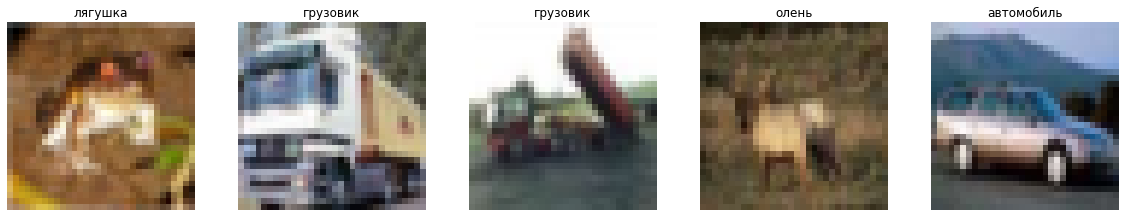

In [ ]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(classes[label.numpy()[0]])
    plt.axis('off')

In [ ]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)

Training data size: 5000
Test data size: 5000


In [ ]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

## Базовый вариант

In [ ]:
model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 384)      

In [ ]:
hist = model.fit(train_ds, 
                 epochs=50,
                 validation_data=test_ds,
                 validation_freq=1)

Epoch 1/50
156/156 [==============================] - 22s 142ms/step - loss: 3.3704 - accuracy: 0.1797 - val_loss: 1.9825 - val_accuracy: 0.2933
Epoch 2/50
156/156 [==============================] - 22s 140ms/step - loss: 2.4503 - accuracy: 0.2644 - val_loss: 1.7802 - val_accuracy: 0.3788
Epoch 3/50
156/156 [==============================] - 22s 140ms/step - loss: 2.1312 - accuracy: 0.3085 - val_loss: 1.6956 - val_accuracy: 0.4151
Epoch 4/50
156/156 [==============================] - 22s 139ms/step - loss: 1.9363 - accuracy: 0.3442 - val_loss: 1.6564 - val_accuracy: 0.4237
Epoch 5/50
156/156 [==============================] - 22s 139ms/step - loss: 1.8397 - accuracy: 0.3732 - val_loss: 1.6346 - val_accuracy: 0.4245
Epoch 6/50
156/156 [==============================] - 22s 138ms/step - loss: 1.7048 - accuracy: 0.4054 - val_loss: 1.5635 - val_accuracy: 0.4505
Epoch 7/50
156/156 [==============================] - 22s 139ms/step - loss: 1.6348 - accuracy: 0.4205 - val_loss: 1.5304 - val_ac

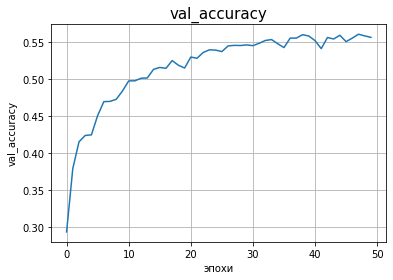

In [ ]:
plt.plot(np.arange(50), hist.history['val_accuracy'])
plt.title('val_accuracy', fontsize=15)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

### Долго обучается даже на GPU Colab'a

## MNIST

In [ ]:
import pandas as pd
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

## Базовый вариант

In [ ]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
x_train.shape[1:]

(28, 28, 1)

In [ ]:
hist = model.fit(x_train, y_train,
              batch_size=32,
              epochs=1000,
              validation_data=(x_test, y_test),
              callbacks=[callback], 
              shuffle=True)

Epoch 1/1000
1875/1875 [==============================] - 16s 9ms/step - loss: 0.6218 - accuracy: 0.7941 - val_loss: 0.1135 - val_accuracy: 0.9653
Epoch 2/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1720 - accuracy: 0.9462 - val_loss: 0.0722 - val_accuracy: 0.9751
Epoch 3/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1267 - accuracy: 0.9608 - val_loss: 0.0553 - val_accuracy: 0.9814
Epoch 4/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1062 - accuracy: 0.9671 - val_loss: 0.0484 - val_accuracy: 0.9839
Epoch 5/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0905 - accuracy: 0.9721 - val_loss: 0.0436 - val_accuracy: 0.9846
Epoch 6/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0811 - accuracy: 0.9747 - val_loss: 0.0365 - val_accuracy: 0.9875
Epoch 7/1000
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0735 - accuracy: 0.9769 - val_loss: 0

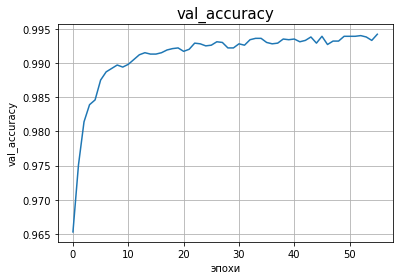

In [ ]:
plt.plot(np.arange(len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
plt.title('val_accuracy', fontsize=15)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

313/313 - 1s - loss: 0.0171 - accuracy: 0.9942
loss: 0.017
accuracy: 0.994


## Генерация сетей и перебор параметров

In [ ]:
def net_gen(lay_cnt=1, filters=16, neurons=256):    # func='relu', 
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(filters, (3, 3), padding='same',
                    input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(filters, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    if not lay_cnt==1:
        model.add(Conv2D(filters*2, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(filters*2, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(neurons))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])

    return model

In [ ]:
def net_iter(model, ep=10, batch_size=512):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=ep,
                        validation_data=(x_test, y_test),
                        verbose=0)
    return history.history

In [ ]:
summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0, 0]], 
                            columns=['layers', 'filters', 'neurons', 'mean_train_accuracy', 'mean_val_accuracy', 'variance', 'l_b', 'r_b'])
cnt = 0
f_n = [16, 32]
l_c = [1, 2]
nr = [256, 512]
epochs = 10

# net_res = []

for l_c_i in l_c:
    for f_n_i in f_n:
        for nr_i in nr:
            err_accuracy = []
            err_val_accuracy = []
            print(f"Модель: слоёв {l_c_i}, фильтров {f_n_i}, нейронов {nr_i}, эпох {epochs}\n")
            model = net_gen(filters=f_n_i, lay_cnt=l_c_i, neurons=nr_i)
            model.summary()
            for i in range(5):
                print(f"\tИтерация: {i+1}")
                hist = net_iter(model, ep=epochs)
                # net_res.append(hist)
                err_accuracy.append(hist['accuracy'][-1])
                err_val_accuracy.append(hist['val_accuracy'][-1])

            vr = np.var(err_val_accuracy)
            l_b, r_b = calculate_confidence_interval(err_val_accuracy)
            mean_err_accuracy, mean_err_val_accuracy = np.mean(err_accuracy), np.mean(err_val_accuracy)
            print(f"Ошибки на train. Средняя: {mean_err_accuracy} список: {err_accuracy}")
            print(f"Ошибки на valid. Средняя: {mean_err_val_accuracy} список: {err_val_accuracy}")
            print(f"Дисперсия ошибки на valid: {vr}")
            print(f"Доверительный интервал: {l_b} - {r_b}\n\n")
            summary_data.loc[cnt, ['layers', 'filters', 'neurons', 'mean_train_accuracy', 
                                    'mean_val_accuracy', 'variance', 'l_b', 'r_b']] = [l_c_i, f_n_i, 
                                    nr_i, np.mean(err_accuracy), np.mean(err_val_accuracy), vr, l_b, r_b]
            cnt += 1

Модель: слоёв 1, фильтров 16, нейронов 256, эпох 10

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_31 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_32 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________


In [ ]:
summary_data

,layers,filters,neurons,mean_train_accuracy,mean_val_accuracy,variance,l_b,r_b
0,1.0,16.0,256.0,0.923780,0.96040,0.000141,0.94158,0.97275
1,1.0,16.0,512.0,0.929533,0.96198,0.000127,0.94378,0.97396
2,1.0,32.0,256.0,0.928897,0.96272,0.000093,0.94641,0.97117
3,1.0,32.0,512.0,0.938950,0.96516,0.000087,0.94943,0.97329
4,2.0,16.0,256.0,0.933573,0.96826,0.000131,0.94924,0.97912
5,2.0,16.0,512.0,0.935067,0.96900,0.000177,0.94670,0.98144
6,2.0,32.0,256.0,0.945570,0.97330,0.000094,0.95716,0.98281
7,2.0,32.0,512.0,0.948770,0.97278,0.000129,0.95392,0.98346


In [ ]:
summary_data.sort_values('mean_val_accuracy', ascending=False)

,layers,filters,neurons,mean_train_accuracy,mean_val_accuracy,variance,l_b,r_b
6,2.0,32.0,256.0,0.945570,0.97330,0.000094,0.95716,0.98281
7,2.0,32.0,512.0,0.948770,0.97278,0.000129,0.95392,0.98346
5,2.0,16.0,512.0,0.935067,0.96900,0.000177,0.94670,0.98144
4,2.0,16.0,256.0,0.933573,0.96826,0.000131,0.94924,0.97912
3,1.0,32.0,512.0,0.938950,0.96516,0.000087,0.94943,0.97329
2,1.0,32.0,256.0,0.928897,0.96272,0.000093,0.94641,0.97117
1,1.0,16.0,512.0,0.929533,0.96198,0.000127,0.94378,0.97396
0,1.0,16.0,256.0,0.923780,0.96040,0.000141,0.94158,0.97275


# Выводы

Сети с большим колличеством свёрточных слоёв и большим количеством фильтров показали лучшее значение метрики на валидационной выборке